## Reading the data

In [1]:
import psycopg2
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname="telecom",  # Database name
    user="postgres",  # Username
    password="root",  # Your PostgreSQL password
    host="localhost"  # Database server
)

# Query to fetch all xDR records
query = "SELECT * FROM xdr_data;"  # Adjust the table name as needed

# Load the data into a pandas DataFrame
df = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Display first few rows of the dataset to understand its structure
print(df.head())

C:\Users\Toshiba\AppData\Local\Temp\ipykernel_11676\2561566250.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

## Data cleaning


In [2]:
df.rename(columns={
    'Dur. (ms)': 'session_duration',
    'Total DL (Bytes)': 'total_dl_bytes',
    'Total UL (Bytes)': 'total_ul_bytes'
}, inplace=True)

# Drop rows where essential columns are missing
df.dropna(subset=['MSISDN/Number'], inplace=True)

# Fill missing values
df['session_duration'].fillna(df['session_duration'].mean(), inplace=True)
df['total_dl_bytes'].fillna(0, inplace=True)
df['total_ul_bytes'].fillna(0, inplace=True)

# Create a column for total traffic
df['total_traffic'] = df['total_dl_bytes'] + df['total_ul_bytes']

# Check for duplicates and remove if necessary
df.drop_duplicates(inplace=True)

# Display summary statistics
print(df.describe())

C:\Users\Toshiba\AppData\Local\Temp\ipykernel_11676\3629669245.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['session_duration'].fillna(df['session_duration'].mean(), inplace=True)
C:\Users\Toshiba\AppData\Local\Temp\ipykernel_11676\3629669245.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

          Bearer Id       Start ms         End ms  session_duration  \
count  1.485060e+05  148935.000000  148935.000000      1.489350e+05   
mean   1.014676e+19     499.246732     498.675442      1.048702e+05   
std    2.893262e+18     288.555630     288.089136      8.106343e+04   
min    6.917538e+18       0.000000       0.000000      7.142000e+03   
25%    7.349883e+18     250.000000     251.000000      5.788350e+04   
50%    7.349883e+18     499.000000     500.000000      8.639900e+04   
75%    1.304243e+19     749.000000     750.000000      1.327000e+05   
max    1.318654e+19     999.000000     999.000000      1.859336e+06   

               IMSI  MSISDN/Number          IMEI  Avg RTT DL (ms)  \
count  1.489350e+05   1.489350e+05  1.489350e+05    121291.000000   
mean   2.082016e+14   4.188282e+10  4.849493e+13       108.224741   
std    1.522166e+10   2.447443e+12  2.242829e+13       594.299952   
min    2.040471e+14   3.360100e+10  4.400152e+11         0.000000   
25%    2.082014

## User Engagement Analysis

        session_duration                                           \
                     min         max           mean           sum   
cluster                                                             
0                83071.0  18553754.0  626185.138982  2.815955e+09   
1                 7258.0    869844.0  164767.463317  6.441090e+09   
2                 7142.0    869830.0  100554.687436  6.361793e+09   

        total_traffic                                            
                  min           max          mean           sum  
cluster                                                          
0         118487293.0  8.846226e+09  2.143717e+09  9.640296e+12  
1         139153646.0  2.299610e+09  9.860550e+08  3.854686e+13  
2          33249009.0  7.871592e+08  4.053660e+08  2.564629e+13  


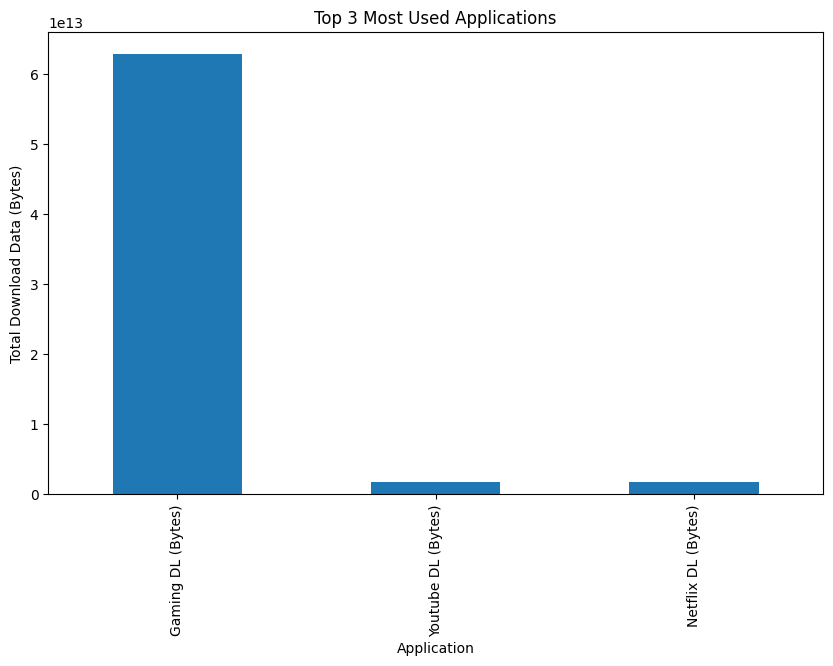

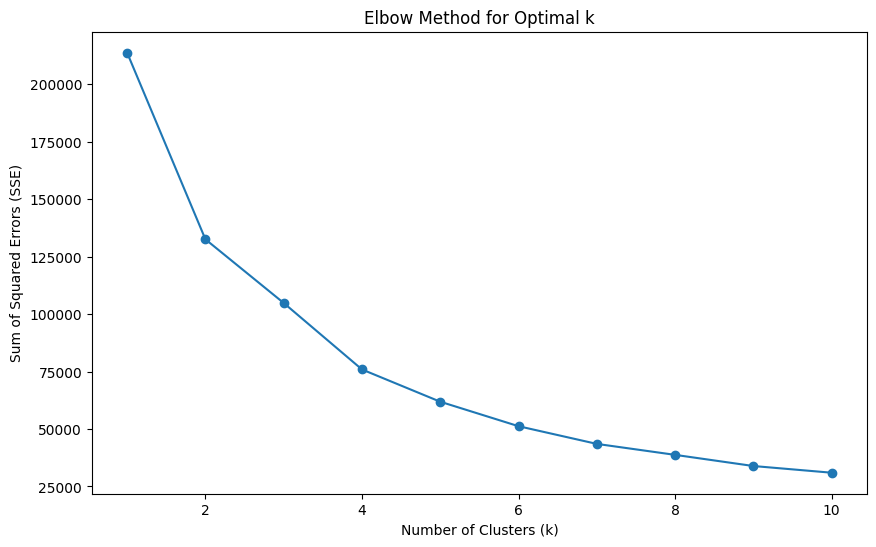

In [3]:
# Aggregate metrics per customer ID
user_engagement = df.groupby('MSISDN/Number').agg({
    'session_duration': 'sum',
    'total_traffic': 'sum'
}).reset_index()

# Normalize the engagement metrics
scaler = StandardScaler()
scaled_engagement = scaler.fit_transform(user_engagement[['session_duration', 'total_traffic']])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
user_engagement['cluster'] = kmeans.fit_predict(scaled_engagement)

# Compute and print metrics for each cluster
cluster_summary = user_engagement.groupby('cluster').agg({
    'session_duration': ['min', 'max', 'mean', 'sum'],
    'total_traffic': ['min', 'max', 'mean', 'sum']
})

print(cluster_summary)

# Plot the top 3 most used applications
app_usage = df[['Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)']].sum()
top_apps = app_usage.nlargest(3)

plt.figure(figsize=(10, 6))
top_apps.plot(kind='bar')
plt.title('Top 3 Most Used Applications')
plt.ylabel('Total Download Data (Bytes)')
plt.xlabel('Application')
plt.show()

# Find the optimized value of k using the Elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_engagement)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()
